In [ ]:
# Replicate ITI results, make sure ITI utils and probing utils work right

#%%
from IPython import get_ipython

ipython = get_ipython()
# Code to automatically update the TransformerLens code as its edited without restarting the kernel
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")
    
import plotly.io as pio
# pio.renderers.default = "png"
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

from tqdm import tqdm
from utils.probing_utils import ModelActs
from utils.dataset_utils import CounterFact_Dataset, TQA_MC_Dataset, EZ_Dataset

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

from utils.iti_utils import patch_iti

from utils.analytics_utils import plot_probe_accuracies, plot_norm_diffs, plot_cosine_sims

In [ ]:
from utils.model_utils import vicuna_7b, vicuna_13b
model = vicuna_7b(device="cuda")
model.tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model_name = "vicuna7b"

In [3]:
from utils.dataset_utils import MS_Dataset, Elem_Dataset, MisCons_Dataset, Kinder_Dataset, HS_Dataset, BoolQ_Question_Dataset, TruthfulQA_Tfn, CounterFact_Tfn, Fever_Tfn, BoolQ_Tfn, Creak_Tfn, CommonClaim_Tfn
random_seed = 5

datanames = ["MS", "Elem", "MisCons", "Kinder", "HS", "TruthfulQA", "CounterFact", "Fever", "Creak", "BoolQ", "CommonClaim"]

ms_data = MS_Dataset(model.tokenizer, questions=True)
elem_data = Elem_Dataset(model.tokenizer, questions=True)
miscons_data = MisCons_Dataset(model.tokenizer, questions=True)
kinder_data = Kinder_Dataset(model.tokenizer, questions=True)
hs_data = HS_Dataset(model.tokenizer, questions=True)
# boolq_data = BoolQ_Question_Dataset(model.tokenizer)

tqa_data = TruthfulQA_Tfn(model.tokenizer, questions=True)
cfact_data = CounterFact_Tfn(model.tokenizer, questions=True)
fever_data = Fever_Tfn(model.tokenizer, questions=True)
boolq_data = BoolQ_Tfn(model.tokenizer, questions=True)
creak_data = Creak_Tfn(model.tokenizer, questions=True)
commonclaim_data = CommonClaim_Tfn(model.tokenizer, questions=True)

datasets = {"MS": ms_data, "Elem": elem_data, "MisCons": miscons_data, "Kinder": kinder_data, "HS": hs_data, "TruthfulQA": tqa_data, "CounterFact": cfact_data, "Fever": fever_data, "Creak": creak_data, "BoolQ": boolq_data, "CommonClaim": commonclaim_data}

datanames = datanames[:3]

In [4]:
n_acts = 1000
acts = {}

for name in datanames:
    # acts[name] = ModelActs(model, datasets[name], act_types=["z", "mlp_out", "resid_post", "resid_pre", "logits"])
    acts[name] = ModelActs(model, datasets[name], act_types=["z", "logits"])
    model_acts: ModelActs = acts[name]
    model_acts.gen_acts(N=n_acts, id=f"{name}_{model_name}_{n_acts}")
    # model_acts.load_acts(id=f"{name}_{model_name}_{n_acts}", load_probes=False)
    model_acts.train_probes("z", max_iter=1000)

100%|██████████| 1000/1000 [01:23<00:00, 12.05it/s]


Stored at MS_vicuna7b_1000
torch.Size([800, 1024, 128]), torch.Size([200, 1024, 128]), torch.Size([800, 1024]), torch.Size([200, 1024])


100%|██████████| 1000/1000 [01:17<00:00, 12.87it/s]


Stored at Elem_vicuna7b_1000
torch.Size([800, 1024, 128]), torch.Size([200, 1024, 128]), torch.Size([800, 1024]), torch.Size([200, 1024])


100%|██████████| 1000/1000 [01:17<00:00, 12.87it/s]


Stored at MisCons_vicuna7b_1000
torch.Size([800, 1024, 128]), torch.Size([200, 1024, 128]), torch.Size([800, 1024]), torch.Size([200, 1024])


100%|██████████| 1024/1024 [00:07<00:00, 129.65it/s]


In [5]:
from utils.interp_utils import logit_attrs
attrs = logit_attrs(model, datasets['MS'], act_types=["result"], N=200)
result_attrs = torch.stack(attrs[1]['result']).to('cpu')

100%|██████████| 200/200 [00:20<00:00,  9.78it/s]


In [14]:
# Plot Truth Score and Info Score when varying topk
from utils.gpt_judge import get_model_generations, get_judge_scores
from utils.iti_utils import patch_heads
from utils.interp_utils import get_head_bools, tot_logit_diff

seed = 0

alpha = 1
k_range = range(0, 4, 1)

logit_patch_accs = []
regular_patch_accs = []
# logit_patch_truths = []
# logit_patch_infos = []
# regular_patch_truths = []
# regular_patch_infos = []
# num_gens=200

# first, patching top logit heads:

dataname = "MS"
for k in tqdm(k_range):
    top_logit_heads = torch.topk(result_attrs.mean(dim=0), k=k).indices

    logit_bools = get_head_bools(model, top_logit_heads, flattened=True)
    model.reset_hooks()
    patch_heads(model, acts[dataname], logit_bools, alpha=alpha, use_probe=True, model_device='cuda')

    patched_acts = ModelActs(model, datasets[dataname], act_types=["z","logits"])
    # print("generating acts")
    patched_acts.gen_acts(N=1000, id=f"patched_{dataname}_{model_name}_1000", indices=acts[dataname].indices, store_acts=False)
    # patched_acts.train_probes("z", max_iter=1000)

    patched_acts.indices_trains=acts[dataname].indices_trains
    patched_acts.indices_tests=acts[dataname].indices_tests

    positive_sum, negative_sum = tot_logit_diff(model.tokenizer, patched_acts, use_probs=True, check_balanced_output=False)

    logit_patch_accs.append(positive_sum.mean() - negative_sum.mean())

 25%|██▌       | 1/4 [01:25<04:16, 85.51s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.465


 50%|█████     | 2/4 [02:45<02:44, 82.38s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.465


 75%|███████▌  | 3/4 [04:07<01:21, 81.91s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.465


100%|██████████| 4/4 [05:26<00:00, 81.67s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.465


In [15]:
from utils.iti_utils import patch_iti
dataname = "MS"
for k in tqdm(k_range):
    model.reset_hooks()
    patch_iti(model, acts[dataname], topk=k, alpha=alpha, use_probe=True, model_device='cuda')

    patched_acts = ModelActs(model, datasets[dataname], act_types=["z","logits"])
    print("generating acts")
    patched_acts.gen_acts(N=1000, id=f"patched_{dataname}_{model_name}_1000", indices=acts[dataname].indices, store_acts=False)

    patched_acts.indices_trains=acts[dataname].indices_trains
    patched_acts.indices_tests=acts[dataname].indices_tests

    positive_sum, negative_sum = tot_logit_diff(model.tokenizer, patched_acts, use_probs=True, check_balanced_output=False)

    regular_patch_accs.append(positive_sum.mean() - negative_sum.mean())

  0%|          | 0/4 [00:00<?, ?it/s]

generating acts


 25%|██▌       | 1/4 [01:24<04:13, 84.46s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.465
generating acts


 50%|█████     | 2/4 [02:46<02:46, 83.22s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.465
generating acts


 75%|███████▌  | 3/4 [04:07<01:22, 82.16s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.465
generating acts


100%|██████████| 4/4 [05:28<00:00, 82.01s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.465


Text(0, 0.5, 'Correct - Incorrect Label Responses')

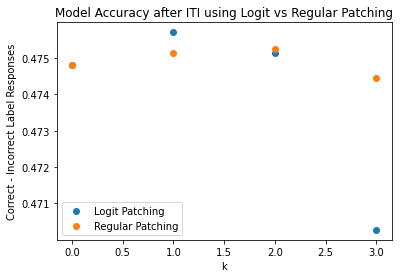

In [16]:
import matplotlib.pyplot as plt

plt.scatter(k_range, logit_patch_accs, label="Logit Patching")
plt.scatter(k_range, regular_patch_accs, label="Regular Patching")
plt.legend()
plt.title("Model Accuracy after ITI using Logit vs Regular Patching")
plt.xlabel("k")
plt.ylabel("Correct - Incorrect Label Responses")

In [18]:
# Now scale output probs so that only correct vs incorrect considered, nothing else
seed = 0

alpha = 1
k_range = range(0, 4, 1)

logit_patch_accs = []
regular_patch_accs = []

dataname = "MS"
for k in tqdm(k_range):
    top_logit_heads = torch.topk(result_attrs.mean(dim=0), k=k).indices

    logit_bools = get_head_bools(model, top_logit_heads, flattened=True)
    model.reset_hooks()
    patch_heads(model, acts[dataname], logit_bools, alpha=alpha, use_probe=True, model_device='cuda')

    patched_acts = ModelActs(model, datasets[dataname], act_types=["z","logits"])
    # print("generating acts")
    patched_acts.gen_acts(N=1000, id=f"patched_{dataname}_{model_name}_1000", indices=acts[dataname].indices, store_acts=False)

    patched_acts.indices_trains=acts[dataname].indices_trains
    patched_acts.indices_tests=acts[dataname].indices_tests

    positive_sum, negative_sum = tot_logit_diff(model.tokenizer, patched_acts, use_probs=True, check_balanced_output=False, scale_relative=True)
    # print(f"{positive_sum=}, {negative_sum=}")
    logit_patch_accs.append(positive_sum.mean() - negative_sum.mean())


dataname = "MS"
for k in tqdm(k_range):
    model.reset_hooks()
    patch_iti(model, acts[dataname], topk=k, alpha=alpha, use_probe=True, model_device='cuda')

    patched_acts = ModelActs(model, datasets[dataname], act_types=["z","logits"])
    print("generating acts")
    patched_acts.gen_acts(N=1000, id=f"patched_{dataname}_{model_name}_1000", indices=acts[dataname].indices, store_acts=False)
    patched_acts.indices_trains=acts[dataname].indices_trains
    patched_acts.indices_tests=acts[dataname].indices_tests

    positive_sum, negative_sum = tot_logit_diff(model.tokenizer, patched_acts, use_probs=True, check_balanced_output=False, scale_relative=True)

    regular_patch_accs.append(positive_sum.mean() - negative_sum.mean())

 25%|██▌       | 1/4 [01:19<03:58, 79.42s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.465


 50%|█████     | 2/4 [02:38<02:38, 79.49s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.465


 75%|███████▌  | 3/4 [03:59<01:20, 80.02s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.465


100%|██████████| 4/4 [05:19<00:00, 79.87s/it]


Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.465


  0%|          | 0/4 [00:00<?, ?it/s]

generating acts


 25%|██▌       | 1/4 [01:21<04:04, 81.44s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.465
generating acts


 50%|█████     | 2/4 [02:41<02:41, 80.55s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.465
generating acts


 75%|███████▌  | 3/4 [04:05<01:21, 81.97s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.465
generating acts


100%|██████████| 4/4 [05:25<00:00, 81.34s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.465


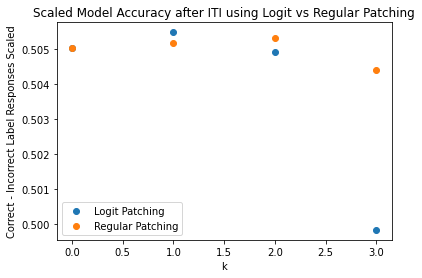

In [19]:

plt.scatter(k_range, logit_patch_accs, label="Logit Patching")
plt.scatter(k_range, regular_patch_accs, label="Regular Patching")
plt.legend()
plt.title("Scaled Model Accuracy after ITI using Logit vs Regular Patching")
plt.xlabel("k")
plt.ylabel("Correct - Incorrect Label Responses Scaled")
plt.show()